# Task Overview

Your task will be to implement a *RevNet* (Reversible Residual Network) – a variant of ResNet where each layer's activations can be reconstructed exactly from the next layer. Therefore, the activations for most layers need not be stored in memory to perform backpropagation.

You can find more information about RevNet here: [link](https://arxiv.org/pdf/1707.04585.pdf)

You should use an MLP architecture trained on the MNIST dataset. You should implement the network in numpy.

Tasks:
1. (10pt) Fill missing code below
  - 1pt implement the `__init__` method
  - 2pt implement the feedforward method
  - 2pt implement the mini-batch update
  - 5pt implement the backpropagation (note: if you implement backpropagation example-by-example instead of whole minibatch at once, you will get maximum of 2pt for this part)
2. Train the models (find proper hyperparameters). Visualize training of your best model (plot training and test loss/accuracy in time). Your model should reach at least 96% accuracy. Use clear ml for logging your scores. Make a comparison of memory usage for your network and the network you implemented in lab 3.
  - 1pt for accuracy above 96%
  - 1pt for visualizations (we recommend downloading plots from clear ml)
  - 2pt if [clear ml](https://clear.ml/docs/latest/docs/) used properly
  - 1pt for comparing memory usage.



## Potential questions, clarifications
- Q: Can I save the output of the last layer before classification (a -> 10)?
  - Yes.
- Q: MNIST has only one channel, how do I split that into two groups for implementing ReVNet blocks?
  - You can split activations into two groups, so if a layer has size $a$ you can split it into $2 \cdot a/2$.
- Q: Can I modify code of ReVNet outside #Your code goes here # to include logging?
  - Yes, in ReVNet.SGD

# Imports

In [ ]:
!pip install clearml --quiet
!pip install memory-profiler --quiet

In [ ]:
import random
import numpy as np
from torchvision import datasets, transforms
from clearml import Task
import plotly.express as px

In [ ]:
%load_ext memory_profiler

# Dataset loading


In [ ]:
!wget -O mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz

In [ ]:
def load_mnist(path='mnist.npz'):
    with np.load(path) as f:
        x_train, _y_train = f['x_train'], f['y_train']
        x_test, _y_test = f['x_test'], f['y_test']

    x_train = x_train.reshape(-1, 28 * 28) / 255.
    x_test = x_test.reshape(-1, 28 * 28) / 255.

    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1

    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()

# Set up clear ml

In [10]:
web_server = 'https://app.clear.ml'
api_server = 'https://api.clear.ml'
files_server= 'https://files.clear.ml'
access_key = "RUKOIR558XOO1LLT6LML"
secret_key = "jJnbyvb8zzOe5ZsLwVipL2dIFuXZeZOTi3DlvIPLAtkG7Yy1Zu"
Task.set_credentials(web_host=web_server,
                     api_host=api_server,
                     files_host=files_server,
                     key=access_key,
                     secret=secret_key)
# Initialize ClearML task
task = Task.init(project_name="DNN", task_name="revnet")


ClearML Task: created new task id=6b63d73ccc7a440382e29a970f40375b
2023-11-27 05:31:50,453 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.clear.ml/projects/06757b9e41344c19acf5d545b4a87086/experiments/6b63d73ccc7a440382e29a970f40375b/output/log


# Network definition (as in laboratory 3)


In [11]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    # Derivative of the sigmoid
    return sigmoid(z)*(1-sigmoid(z))

class Network(object):
    def __init__(self, sizes):
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
    def feedforward(self, a):
        # Run the network on a batch
        a = a.T
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.matmul(w, a)+b)
        return a

    def update_mini_batch(self, mini_batch, eta):
        # Update networks weights and biases by applying a single step
        # of gradient descent using backpropagation to compute the gradient.
        # The gradient is computed for a mini_batch which is as in tensorflow API.
        # eta is the learning rate
        nabla_b, nabla_w = self.backprop(mini_batch[0].T,mini_batch[1].T)

        self.weights = [w-(eta/len(mini_batch[0]))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch[0]))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        # For a single input (x,y) return a pair of lists.
        # First contains gradients over biases, second over weights.
        g = x
        gs = [g] # list to store all the gs, layer by layer
        fs = [] # list to store all the fs, layer by layer
        for b, w in zip(self.biases, self.weights):
            f = np.dot(w, g)+b
            fs.append(f)
            g = sigmoid(f)
            gs.append(g)
        # backward pass <- both steps at once
        dLdg = self.cost_derivative(gs[-1], y)
        dLdfs = []
        for w,g in reversed(list(zip(self.weights,gs[1:]))):
            dLdf = np.multiply(dLdg,np.multiply(g,1-g))
            dLdfs.append(dLdf)
            dLdg = np.matmul(w.T, dLdf)

        dLdWs = [np.matmul(dLdf,g.T) for dLdf,g in zip(reversed(dLdfs),gs[:-1])]
        dLdBs = [np.sum(dLdf,axis=1).reshape(dLdf.shape[0],1) for dLdf in reversed(dLdfs)]
        return (dLdBs,dLdWs)

    def evaluate(self, test_data):
        # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(test_data[0]),axis=0)
        corr = np.argmax(test_data[1],axis=1).T
        return np.mean(pred==corr)

    def cost_derivative(self, output_activations, y):
        return (output_activations-y)

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        for j in range(epochs):
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                y_mini_batch = y_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                self.update_mini_batch((x_mini_batch, y_mini_batch), eta)
            if test_data:
                print("Epoch: {0}, Accuracy: {1}".format(j, self.evaluate((x_test, y_test))))
            else:
                print("Epoch: {0}".format(j))


# ReVNet definition

RevNets are composed of a series of reversible blocks. The channels (in case of MNIST: activations) in each layer are partitioned into two groups (two vectors), denoted $x_1$ and $x_2$.

Forward: Each reversible block takes inputs ($x_1$, $x_2$) and produces outputs produces outputs ($y_1$, $y_2$) using functions F and G (the *residuals*). In this task, implement F and G as MLP layers.

$z_1 = x_1 + \mathcal{F}(x_2)$

$y_2 = x_2 + \mathcal{G}(z_1)$

$y_1 = z_1$

The expressions $y_1$ and $z_1$ have the same value, but they are separate nodes in the computation graph, with $y_2$ depending on $z_1$, not $y_1$. We use this distinction so that we can describe gradient computations in two steps: $∂ℒ/∂y_1$ is the derivative of the loss over $y_1$ when $y_2$ is a fixed constant, while $∂ℒ/∂z_1$ is the derivative over $z_1$, which influences the loss through both y1 and y2.

Reverse: Each layer’s activations can be reconstructed from the next layer’s activations as follows:

$x_2 = y_2 - \mathcal{G}(y_1)$

$x_1 = y_1 - \mathcal{F}(x_2)$

Backpropagation is described in the algorithm below, ($y_1$, $y_2$).
$\bar{y_1}$, $\bar{y_2}$ is the gradient of the loss over $y_1$ and $y_2$, respectively


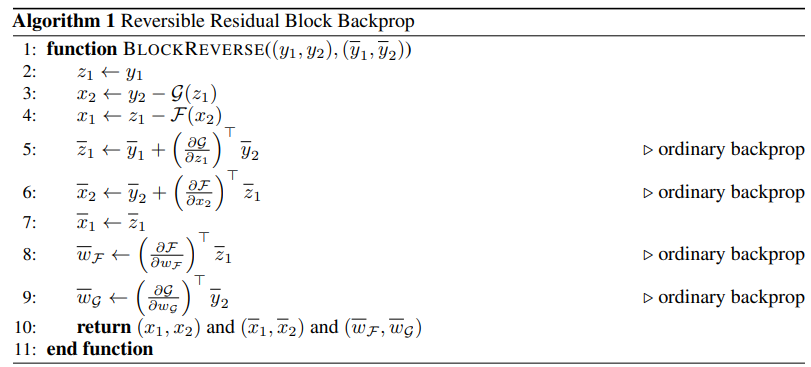

In [12]:
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=0))
    return e_x / np.sum(e_x, axis=0)

def cross_entropy(predictions, targets):
  epsilon = 1e-14
  predictions = np.clip(predictions, epsilon, 1. - epsilon)
  N = predictions.shape[0]
  ce = -np.sum(targets*np.log(predictions+1e-9))/N
  return ce

class ReVNet(object):
  def __init__(self, sizes):
    self.sizes = sizes
    # initialize biases and weights with random normal distr.
    # weights are indexed by target node first
    # sizes should be in form (mnist_size, a, a, a, ...,  a, 10)
    # IMPORTANT: use at least one layer of size a -> a
    self.num_layers = len(sizes)

    self.biases = [[np.random.randn(self.sizes[1], 1)]]
    for y in self.sizes[2:-1]:
      self.biases.append(np.array([np.random.randn(y//2, 1), np.random.randn(y//2, 1)]))
    self.biases.append([np.random.randn(self.sizes[-1], 1)])

    self.weights = [[np.random.randn(sizes[1], sizes[0])]]
    for x, y in zip(sizes[1:-2], sizes[2:-1]):
      self.weights.append(np.array([np.random.randn(y//2, x//2),np.random.randn(y//2, x//2)]))
    self.weights.append([np.random.randn(sizes[-1], sizes[-2])])

    assert len(self.sizes) > 3
    assert self.sizes[-1] == 10
    for i in range(len(self.sizes)-3): assert self.sizes[i+1] == self.sizes[i+2]

  def rev_block_forward(self, x, w, b):
    x1, x2 = np.split(x, 2, axis=0)

    z1 = x1 + self.F(x2, w=w[0], b=b[0])
    y2 = x2 + self.G(z1, w=w[1], b=b[1])
    y1 = z1
    res = np.concatenate((y1, y2), axis=0)
    return res

  def F(self, x, w, b, act = sigmoid):
    # Forward pass for a simple MLP layer
    z = act(np.matmul(w, x)+b)
    return z

  def G(self, x, w, b, act = sigmoid):
    # Forward pass for a simple MLP layer
    z = act(np.matmul(w, x)+b)
    return z

  def feedforward(self, a):
    a = a.T
    a = self.F(x=a, w=self.weights[0][0], b=self.biases[0][0])
    for b, w in zip(self.biases[1:-1], self.weights[1:-1]):
        a = self.rev_block_forward(x=a,w=w, b=b)
    a = self.F(x=a, w=self.weights[-1][0], b=self.biases[-1][0], act=softmax)
    return a

  def feedforward2(self, a):
    a = a.T
    a = self.F(x=a, w=self.weights[0][0], b=self.biases[0][0])
    for b, w in zip(self.biases[1:-1], self.weights[1:-1]):
        a = self.rev_block_forward(x=a,w=w, b=b)
    last = a
    a = self.F(x=a, w=self.weights[-1][0], b=self.biases[-1][0], act=softmax)
    return a, last

  def update_mini_batch(self, x_mini_batch, y_mini_batch, eta):
    # Update networks weights and biases by applying a single step
    # of gradient descent using backpropagation to compute the gradient.
    # The gradient is computed for a mini_batch.
    # eta is the learning rate
    nabla_b, nabla_w = self.backpropagation(x_mini_batch.T, y_mini_batch.T)

    N = len(x_mini_batch)
    for layer in range(len(self.weights)):
      for part in range(len(self.weights[layer])):
        self.weights[layer][part] -= (eta/N) * nabla_w[layer][part]

    for layer in range(len(self.biases)):
      for part in range(len(self.biases[layer])):
        self.biases[layer][part] -= (eta/N) * nabla_b[layer][part].reshape((-1, 1))


  def blockreverse(self, y, y_prime, w, b):
    z1 = y[0]

    g=self.G(x=z1, w=w[1], b=b[1])
    x2 = y[1] - g

    f=self.F(x=x2, w=w[0], b=b[0])
    x1 = z1 - f

    g_prime = np.multiply(y_prime[1], np.multiply(g,1-g))
    z1_prime = y_prime[0] + np.matmul(w[1].T, g_prime)

    f_prime = np.multiply(z1_prime, np.multiply(f,1-f))
    x2_prime = y_prime[1] + np.matmul(w[0].T, f_prime)

    x1_prime = z1_prime
    wf = f_prime @ x2.T
    wg = g_prime @ x1.T
    return [x1, x2], [x1_prime, x2_prime], wf, wg

  def backpropagation(self, x, y):
      nabla_w, nabla_b = [], []
      last, prawie_last = self.feedforward2(x.T)

      dLdg = self.cost_derivative(last, y)

      nabla_w.append([np.matmul(dLdg, prawie_last.T)])
      nabla_b.append([np.sum(dLdg,axis=1)])

      dLdy = np.matmul(self.weights[-1][0].T, dLdg)
      y_ = np.split(prawie_last, 2, axis=0)
      y_prime = np.split(dLdy, 2, axis=0)

      for w, b in reversed(list(zip(self.weights[1:-1], self.biases[1:-1]))):
        y_, y_prime, w_f, w_g = self.blockreverse(y_, y_prime, w=w, b=b)
        nabla_b.append([np.sum(y_prime[0],axis=1),np.sum(y_prime[1],axis=1)])
        nabla_w.append([w_f, w_g])

      y_ = np.vstack((y_[0], y_[1]))
      dLdy = np.vstack((y_prime[0], y_prime[1]))

      dLdf = np.multiply(dLdy, np.multiply(y_, 1 - y_))
      nabla_w.append([np.matmul(dLdf, x.T)])
      nabla_b.append([np.sum(dLdf,axis=1)])

      return nabla_b[::-1], nabla_w[::-1]


  def cost_derivative(self, output_activations, y):
    return (output_activations-y)

  def evaluate(self, x_test_data, y_test_data):
      # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(x_test_data),axis=0)
        corr = np.argmax(y_test_data,axis=1).T
        return np.mean(pred==corr)


  def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
      logger = task.get_logger()
      x_train, y_train = training_data
      if test_data:
          x_test, y_test = test_data
      for j in range(epochs):
          for i in range(x_train.shape[0] // mini_batch_size):
              x_mini_batch = x_train[i*mini_batch_size:(i*mini_batch_size + mini_batch_size)]
              y_mini_batch = y_train[i*mini_batch_size:(i*mini_batch_size + mini_batch_size)]
              self.update_mini_batch(x_mini_batch, y_mini_batch, eta)
          if test_data:

              print("Epoch: {0}, Accuracy: {1}".format(j, self.evaluate(x_test, y_test)))
          else:
              print("Epoch: {0}".format(j))


# Train the network

In [263]:
network = ReVNet([784, 200, 200, 10])
network.SGD((x_train, y_train), epochs=50, mini_batch_size=100, eta=5.7, test_data=(x_test, y_test))

Epoch: 0, Accuracy: 0.9095
Epoch: 1, Accuracy: 0.9327
Epoch: 2, Accuracy: 0.9393
Epoch: 3, Accuracy: 0.9465
Epoch: 4, Accuracy: 0.9484
Epoch: 5, Accuracy: 0.9527
Epoch: 6, Accuracy: 0.9522
Epoch: 7, Accuracy: 0.9546
Epoch: 8, Accuracy: 0.9557
Epoch: 9, Accuracy: 0.9537
Epoch: 10, Accuracy: 0.9544
Epoch: 11, Accuracy: 0.9553
Epoch: 12, Accuracy: 0.956
Epoch: 13, Accuracy: 0.958
Epoch: 14, Accuracy: 0.9578
Epoch: 15, Accuracy: 0.9584
Epoch: 16, Accuracy: 0.9607
Epoch: 17, Accuracy: 0.959
Epoch: 18, Accuracy: 0.9602
Epoch: 19, Accuracy: 0.9599
Epoch: 20, Accuracy: 0.96
Epoch: 21, Accuracy: 0.96
Epoch: 22, Accuracy: 0.9597
Epoch: 23, Accuracy: 0.9582
Epoch: 24, Accuracy: 0.9599
Epoch: 25, Accuracy: 0.9605
Epoch: 26, Accuracy: 0.9605
Epoch: 27, Accuracy: 0.9607
Epoch: 28, Accuracy: 0.9607
Epoch: 29, Accuracy: 0.961
Epoch: 30, Accuracy: 0.9621
Epoch: 31, Accuracy: 0.9621
Epoch: 32, Accuracy: 0.9622
Epoch: 33, Accuracy: 0.9619
Epoch: 34, Accuracy: 0.9619
Epoch: 35, Accuracy: 0.9613
Epoch: 36,

# Training plots for the best training

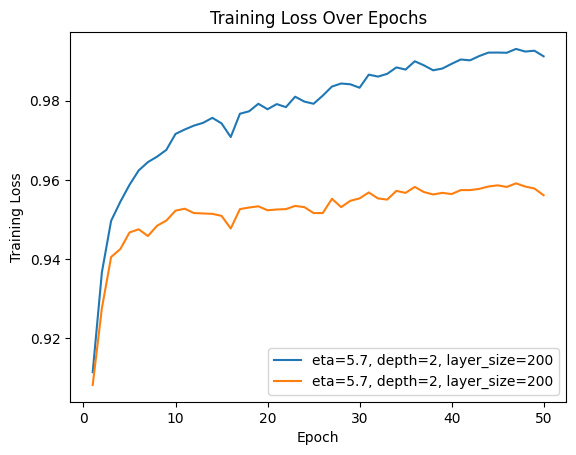

<ipython-input-11-5dcad92691ea>:2: RuntimeWarning:

overflow encountered in exp



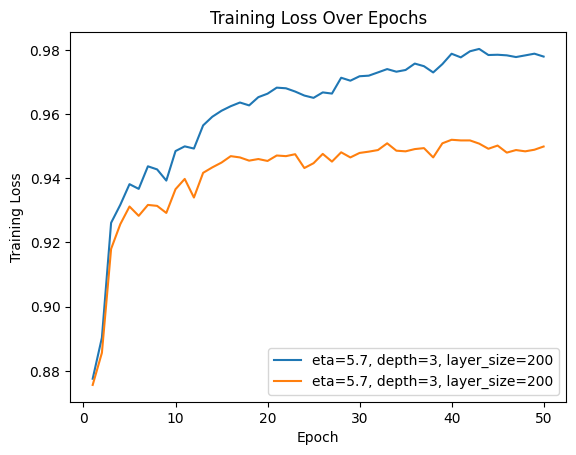

In [16]:
import matplotlib.pyplot as plt

etas = [ 5.7]
sizes = [100]
depths = [2, 3]
layers = [200]
epochs = 50
batch_size = 100

for eta in etas:
    for depth in depths:
        for layer_size in layers:
            architecture = [784]
            for i in range(depth):
                architecture.append(layer_size)
            architecture.append(10)

            # Create ReVNet instance with the current architecture
            network = ReVNet(architecture)

            # Train the network and evaluate on the test data
            train_accuracy_history = []  # To store training loss for plotting
            test_accuracy_history = []
            for epoch in range(epochs):
                for i in range(x_train.shape[0] // batch_size):
                    x_mini_batch = x_train[i*batch_size:(i*batch_size + batch_size)]
                    y_mini_batch = y_train[i*batch_size:(i*batch_size + batch_size)]
                    network.update_mini_batch(x_mini_batch, y_mini_batch, eta)

                # Calculate and log training loss for this epoch
                train_accuracy = network.evaluate(x_train, y_train)
                train_accuracy_history.append(train_accuracy)


                test_accuracy = network.evaluate(x_test, y_test)
                test_accuracy_history.append(test_accuracy)

                # Log training loss to ClearML
                task.get_logger().report_scalar(
                    title='Accuracy', series=f'Train_{eta}_{depth}_{layer_size}', iteration=epoch, value=train_accuracy
                )

                task.get_logger().report_scalar(
                    title='Accuracy', series=f'Test_{eta}_{depth}_{layer_size}', iteration=epoch, value=test_accuracy
                )

            # Plot training loss over epochs
            plt.plot(range(1, epochs + 1), train_accuracy_history, label=f"eta={eta}, depth={depth}, layer_size={layer_size}")
            plt.plot(range(1, epochs + 1), test_accuracy_history, label=f"eta={eta}, depth={depth}, layer_size={layer_size}")
            plt.xlabel("Epoch")
            plt.ylabel("Training Loss")
            plt.legend()
            plt.title("Training Loss Over Epochs")
            plt.show()

In [26]:
task.close()

# Compare memory usage

Hint: you can use memory-profiler library [link](https://pypi.org/project/memory-profiler/)

In [262]:
from memory_profiler import profile

@profile
def compare_memory(network):
    network.SGD((x_train, y_train), epochs=5, mini_batch_size=100, eta=3., test_data=(x_test, y_test))

%memit compare_memory(ReVNet([784,500,500,10]))
%memit compare_memory(Network([784,500,500,10]))

ERROR: Could not find file <ipython-input-262-fc5cd6a5d451>
NOTE: %mprun can only be used on functions defined in physical files, and not in the IPython environment.
Epoch: 0, Accuracy: 0.9206
Epoch: 1, Accuracy: 0.9367
Epoch: 2, Accuracy: 0.9431
Epoch: 3, Accuracy: 0.9474
Epoch: 4, Accuracy: 0.9501
peak memory: 1716.72 MiB, increment: 111.46 MiB
ERROR: Could not find file <ipython-input-262-fc5cd6a5d451>
NOTE: %mprun can only be used on functions defined in physical files, and not in the IPython environment.
Epoch: 0, Accuracy: 0.2718
Epoch: 1, Accuracy: 0.538
Epoch: 2, Accuracy: 0.5681
Epoch: 3, Accuracy: 0.5739
Epoch: 4, Accuracy: 0.5773
peak memory: 1757.17 MiB, increment: 152.66 MiB
